# Persistent English Auctions - Simulation

A sequential clearing auction mechanism inspired by English auctions for maximising bid transparency and revenue.

We consider the situation in which a NFT artist would like to sell a collection of NFTs. They do not know what would be a fair price and thus resort to an auction.

In a persistent English auction, the auctioneer decides the rate at which NFTs should be sold at e.g 1 NFT per hour. Whilst the auction is active, potential buyers can register bids. In theory, at the end of every hour (a clearing round), a sale is made to the highest bidder. This is done until all pieces are sold.

Lazy evaluation is used to amortise the cost of operating the auction on the blockchain. Before a bid is made, the time gap between the previous transaction is calculated to see if any previous clearing rounds need to be processed. This is inspired by the concept of virtual orders used in [TWAMMs](https://www.paradigm.xyz/2021/07/twamm#the-time-weighted-average-market-maker).

Upon auction close, participants can mint their NFTs and/or claim their funds from unsuccessful bids.

This notebook simulates the running of a persistent English auction due to the simple mechanism to choose the winner every clearing round.

## Dependencies

In [49]:
%pip install names

Note: you may need to restart the kernel to use updated packages.


In [50]:
# Simulated Auction
from pea import PersistentEnglishAuction
from random import randint, uniform, triangular
import numpy as np
import names
from math import ceil

# Plotting
import matplotlib.pyplot as plt

## Auction Setup

In [51]:
# Auction configuration presets
TIME_BETWEEN_CLEARING = 2
MAX_CLEARS = 10
AUCTION_START_TIME = 2
BIDS = 50

# Simulation configuration presets
SIMULATION_RUNS = 1000

In [52]:
# Create a completely new auction
def new_auction(time_between_clearing = TIME_BETWEEN_CLEARING,
                max_clears = MAX_CLEARS,
                auction_start_time = AUCTION_START_TIME):
    return PersistentEnglishAuction(time_between_clearing=time_between_clearing,
                                   max_clears=max_clears,
                                   auction_start_time=auction_start_time)

def apply_bids(auction, x, y):
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]
    
    for i in range(len(x)):
        auction.add_bid(address=names.get_first_name(), bid=y[i], bid_time=x[i])
    auction.close_auction()
    
def get_revenues(auction):
    bidders = auction.get_bidders()
    winners = auction.get_winners()
    all_bids = np.array([bid[0] for bid in (bidders + winners)])
    all_bids = all_bids[np.argsort(all_bids)]
    
    actual_revenue = sum([-winner[0] for winner in winners])
    potential_max_revenue = sum([-bid for bid in all_bids[:MAX_CLEARS]])
    return actual_revenue, potential_max_revenue

def plot_winnings(auction):
    bidders = auction.get_bidders()
    winners = auction.get_winners()
    
    actual_revenue, potential_max_revenue = get_revenues(auction)
    print("Actual maximum revenue: ", actual_revenue)
    print("Potential maximum revenue: ", potential_max_revenue)

    plt.plot([bidder[1] for bidder in bidders], [(-bidder[0]) for bidder in bidders], 'o', color='black')
    plt.plot([winner[1] for winner in winners], [(-winner[0]) for winner in winners], 'o', color="orange")

## Simple Linear Generation

Actual maximum revenue:  896.3848421954324
Potential maximum revenue:  896.3848421954324


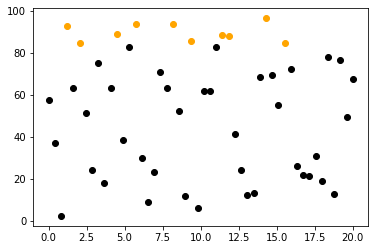

In [53]:
auction = new_auction()

# Generate random bids made in a linear fashion
x = np.linspace(0, TIME_BETWEEN_CLEARING * MAX_CLEARS, BIDS)
y = np.array([uniform(0, 100) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [54]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids made in a linear fashion
    x = np.linspace(0, TIME_BETWEEN_CLEARING * MAX_CLEARS, BIDS)
    y = np.array([uniform(0, 100) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  878089.5023310429
Total potential maximum revenue:  892183.4863653383
Total Efficiency:  98.42 %


## Randomised 2D Generation 

Actual maximum revenue:  853.195477266523
Potential maximum revenue:  872.7581579897203


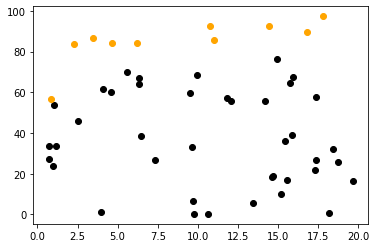

In [55]:
auction = new_auction()

# Generate random bids made in a 2D random fashion
x = np.array([uniform(0, TIME_BETWEEN_CLEARING * MAX_CLEARS) for _ in range(0, BIDS)])
y = np.array([uniform(0, 100) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [56]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids made in a 2D random fashion
    x = np.array([uniform(0, TIME_BETWEEN_CLEARING * MAX_CLEARS) for _ in range(0, BIDS)])
    y = np.array([uniform(0, 100) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  873415.5289860608
Total potential maximum revenue:  891410.0544295221
Total Efficiency:  97.98 %


## Normal Auction Sniping

Actual maximum revenue:  440.66226767454884
Potential maximum revenue:  715.1603237633261


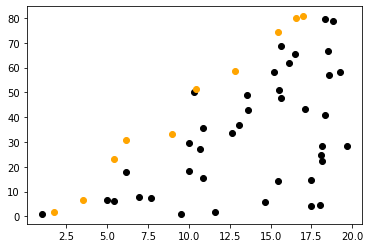

In [57]:
auction = new_auction()

# Generate random bids
FULL_AUCTION_DURATION = TIME_BETWEEN_CLEARING * MAX_CLEARS
x = np.array([triangular(0, FULL_AUCTION_DURATION, FULL_AUCTION_DURATION) for _ in range(0, BIDS)])
y = np.array([uniform(0, math.ceil(num / FULL_AUCTION_DURATION * 100)) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [58]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids
    FULL_AUCTION_DURATION = TIME_BETWEEN_CLEARING * MAX_CLEARS
    x = np.array([triangular(0, FULL_AUCTION_DURATION, FULL_AUCTION_DURATION) for _ in range(0, BIDS)])
    y = np.array([uniform(0, ceil(num / FULL_AUCTION_DURATION * 100)) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  433905.12938280695
Total potential maximum revenue:  699320.9547917946
Total Efficiency:  62.05 %


## Attuned Auction Sniping

Actual maximum revenue:  718.0826297007474
Potential maximum revenue:  719.8670997451862


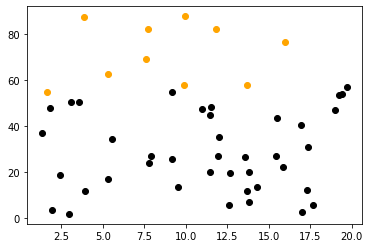

In [59]:
auction = new_auction()

# Generate random bids
FULL_AUCTION_DURATION = TIME_BETWEEN_CLEARING * MAX_CLEARS
x = np.array([[triangular(i * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING) for i in range(0, MAX_CLEARS)][randint(0, MAX_CLEARS - 1)] for _ in range(0, BIDS)])
y = np.array([uniform(0, ceil((num % TIME_BETWEEN_CLEARING) / TIME_BETWEEN_CLEARING * 100)) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [60]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids
    x = np.array([[triangular(i * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING) for i in range(0, MAX_CLEARS)][randint(0, MAX_CLEARS - 1)] for _ in range(0, BIDS)])
    y = np.array([uniform(0, ceil((num % TIME_BETWEEN_CLEARING) / TIME_BETWEEN_CLEARING * 100)) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  679275.3280151109
Total potential maximum revenue:  699514.5894117551
Total Efficiency:  97.11 %


## Generous Bidding

Actual maximum revenue:  901.0910878402298
Potential maximum revenue:  948.5697038876606


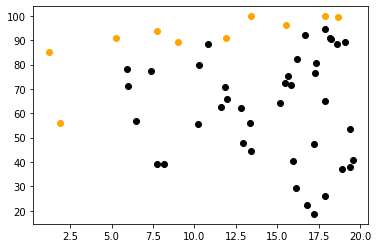

In [61]:
auction = new_auction()

# Generate random bids
x = np.array([triangular(0, TIME_BETWEEN_CLEARING * MAX_CLEARS, TIME_BETWEEN_CLEARING * MAX_CLEARS) for _ in range(0, BIDS)])
y = np.array([triangular(0, 100, 100) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [62]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids
    x = np.array([triangular(0, TIME_BETWEEN_CLEARING * MAX_CLEARS, TIME_BETWEEN_CLEARING * MAX_CLEARS) for _ in range(0, BIDS)])
    y = np.array([triangular(0, 100, 100) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  870166.6417001042
Total potential maximum revenue:  943948.6649678039
Total Efficiency:  92.18 %


## Attuned Generous Bidding

Actual maximum revenue:  959.2951238788509
Potential maximum revenue:  967.7103050717889


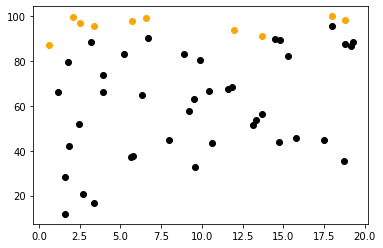

In [63]:
auction = new_auction()

# Generate random bids
x = np.array([[triangular(i * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING) for i in range(0, MAX_CLEARS)][randint(0, MAX_CLEARS - 1)] for _ in range(0, BIDS)])
y = np.array([triangular(0, 100, 100) for num in x])

apply_bids(auction, x, y)
plot_winnings(auction)

In [64]:
# Bulk Simulation Runs
total_actual_revenue = 0
total_potential_max_revenue = 0
for run_i in range(0, SIMULATION_RUNS):
    auction = new_auction()

    # Generate random bids
    x = np.array([[triangular(i * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING, (i + 1) * TIME_BETWEEN_CLEARING) for i in range(0, MAX_CLEARS)][randint(0, MAX_CLEARS - 1)] for _ in range(0, BIDS)])
    y = np.array([triangular(0, 100, 100) for num in x])

    apply_bids(auction, x, y)
    actual_revenue, potential_max_revenue = get_revenues(auction)
    
    total_actual_revenue += actual_revenue
    total_potential_max_revenue += potential_max_revenue

print("Total actual revenue: ", total_actual_revenue)
print("Total potential maximum revenue: ", total_potential_max_revenue)    
print("Total Efficiency: ", round(total_actual_revenue / total_potential_max_revenue * 100, 2), "%")

Total actual revenue:  932240.6342343673
Total potential maximum revenue:  942754.0783889286
Total Efficiency:  98.88 %
